In [1]:
# needs summary.h5 from https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/maf/summary.h5

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os
import glob

import rubin_sim.maf as maf

from matplotlib.legend_handler import HandlerErrorbar

In [3]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [4]:
data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(239, 396218)

In [5]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'Y1,u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'Y1,g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'Y1,r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'Y1,i',
    'best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            #'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
            #'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            #'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Sum ColorSlope visitExposureTime > 19 HealpixSlicer': 'color\nslope',
            "Sum ColorSlope2Night visitExposureTime > 19 HealpixSlicer": "2day\ncolor slope",
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'Y1,u': '',
         'Y1,g': '',
         'Y1,r': '',
         'Y1,i': '',
         'color\nslope': 'N',
         '2day\ncolor slope': 'N',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan',
           'u', 'g', 'r', 'i', 'z', 'y']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

# Compared to v3.3

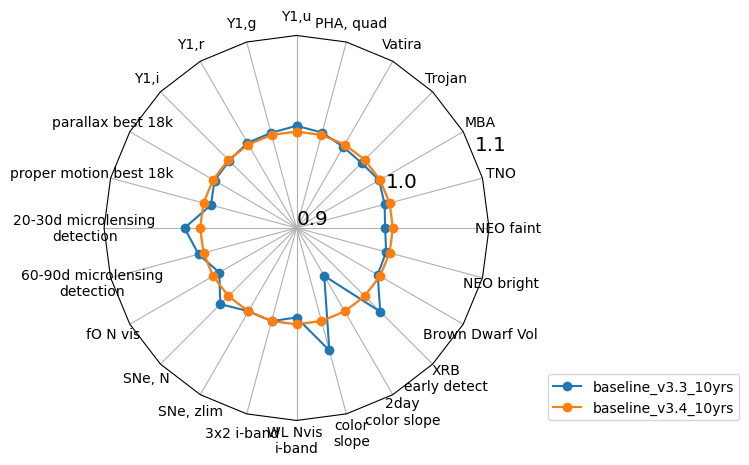

In [6]:
runs = ['baseline_v3.3_10yrs', 'baseline_v3.4_10yrs' ]

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

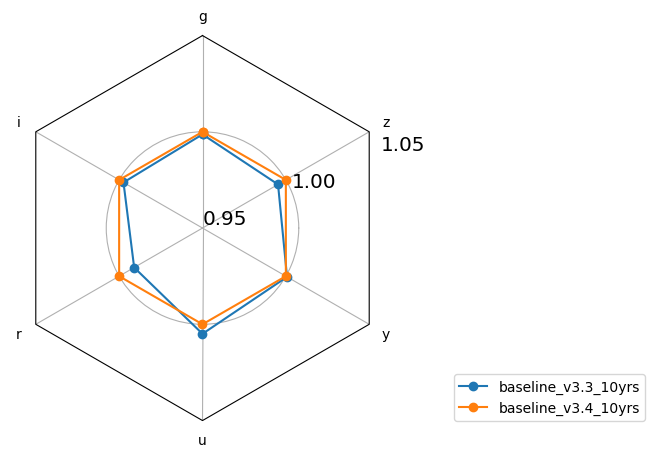

In [7]:
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')#, invert_cols=['u', 'g', 'r', 'i', 'z', 'y'])
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

# Note magnitude of variations from survey start date change

Trojan variation probably real (if we get a trojan cloud before/after it moves through the lower sampled NES)

For most of the others, the changes are not due to any change in the survey strategy, just the variation that can happen because of the dynamic nature of the scheduler.

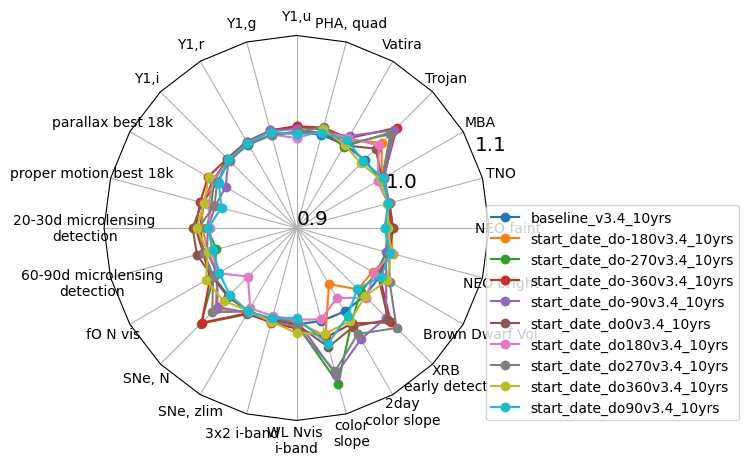

In [8]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'start' in run ] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [9]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs', 'baseline_v3.4_10yrs', 'roll_uniform_mjdp0_v3.4_10yrs']

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)




/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_79829/3763499284.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


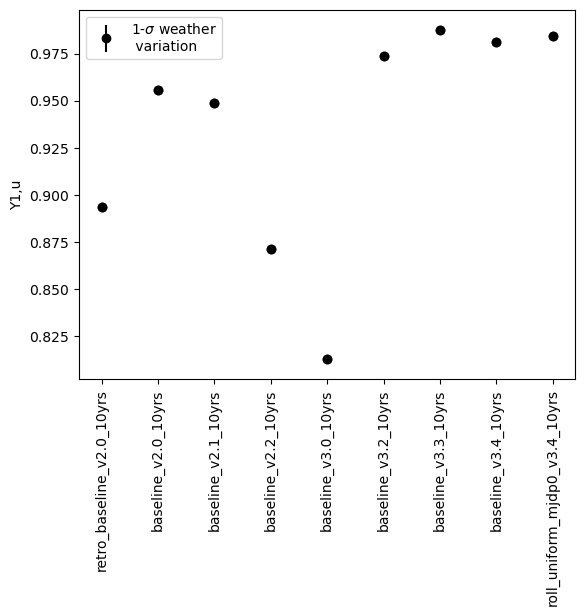

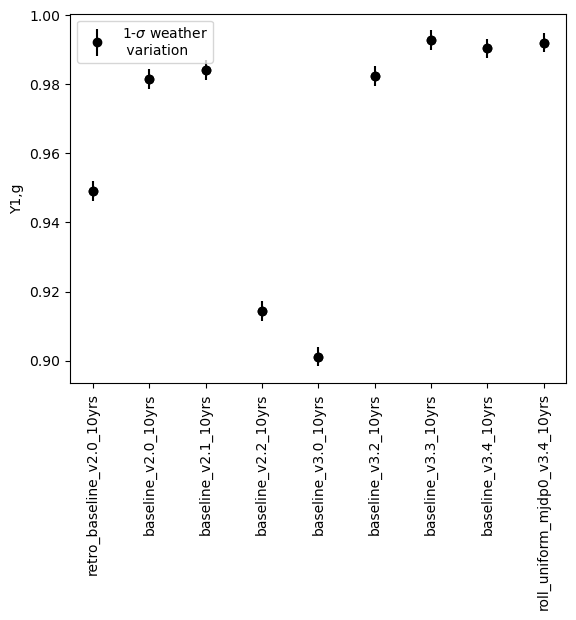

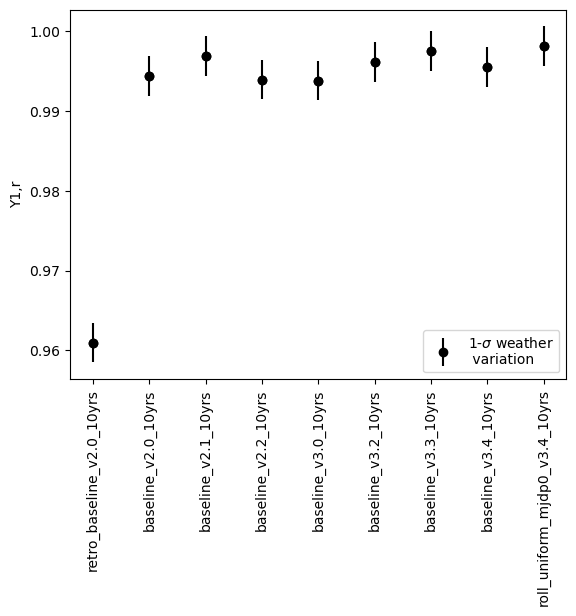

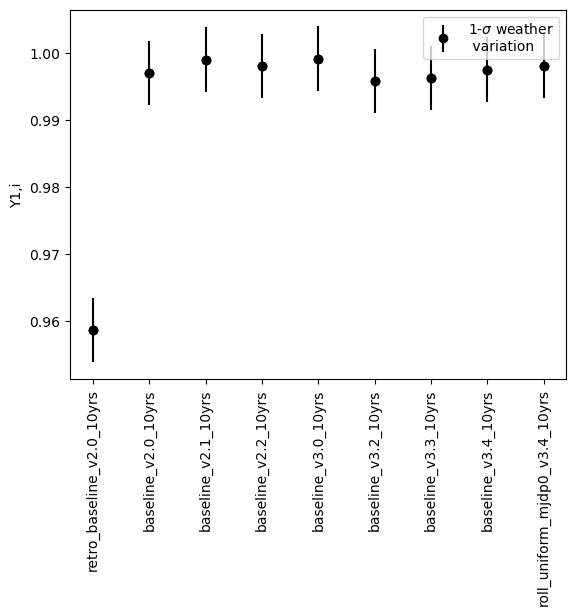

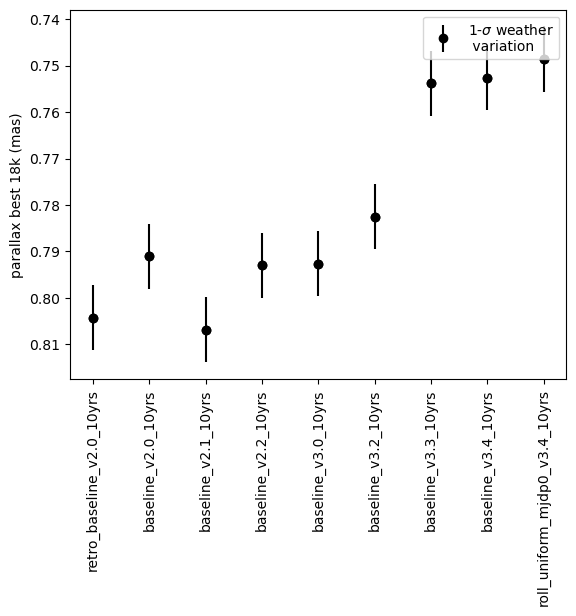

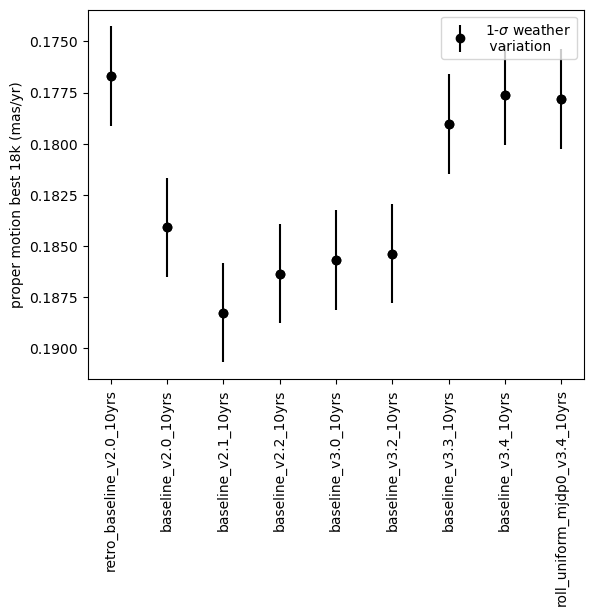

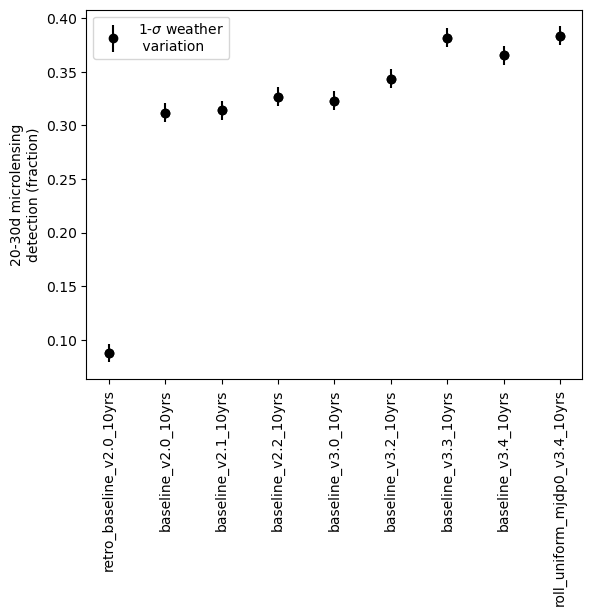

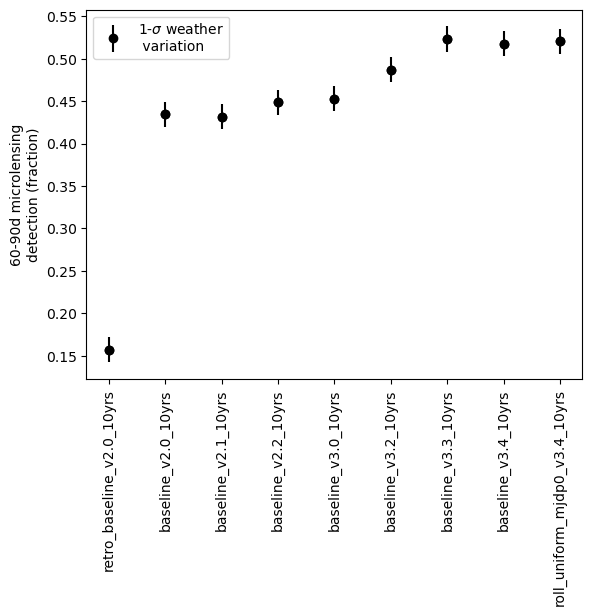

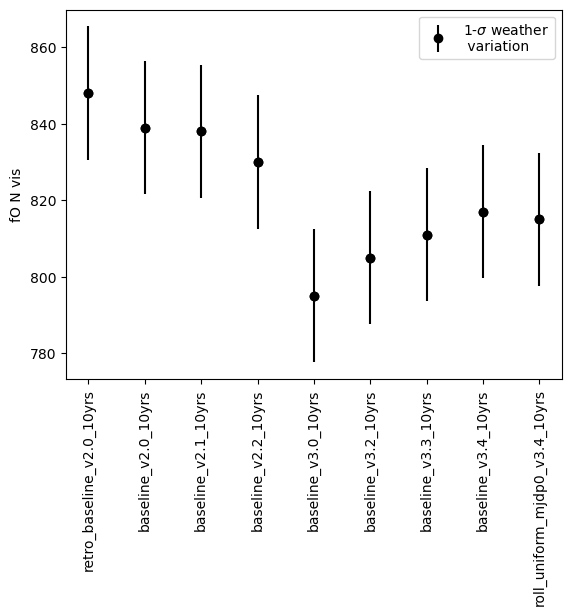

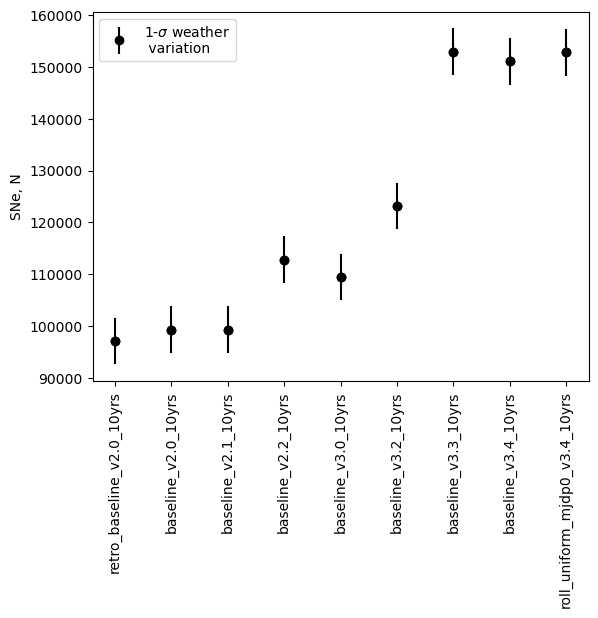

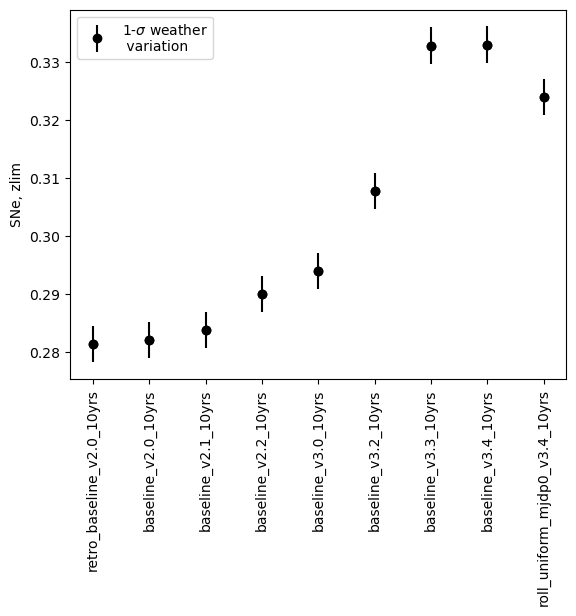

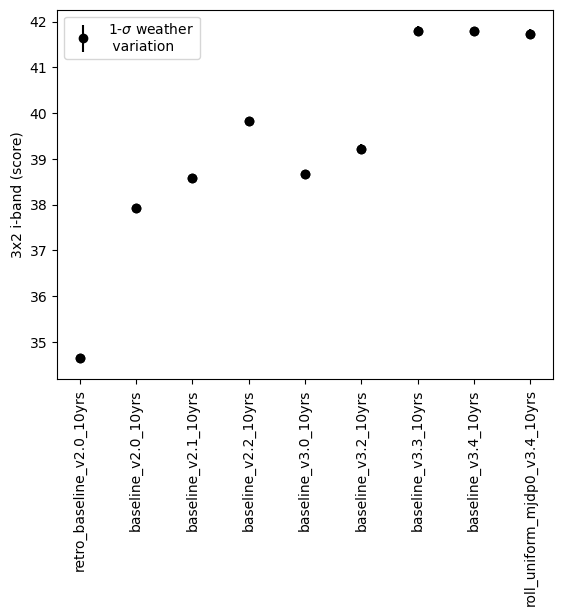

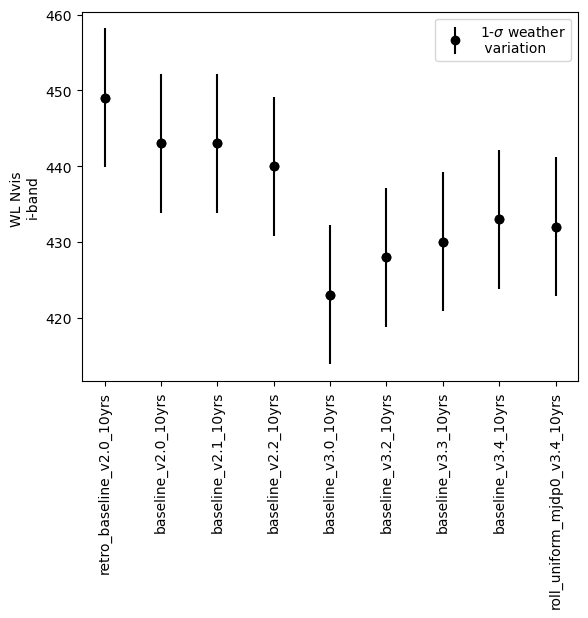

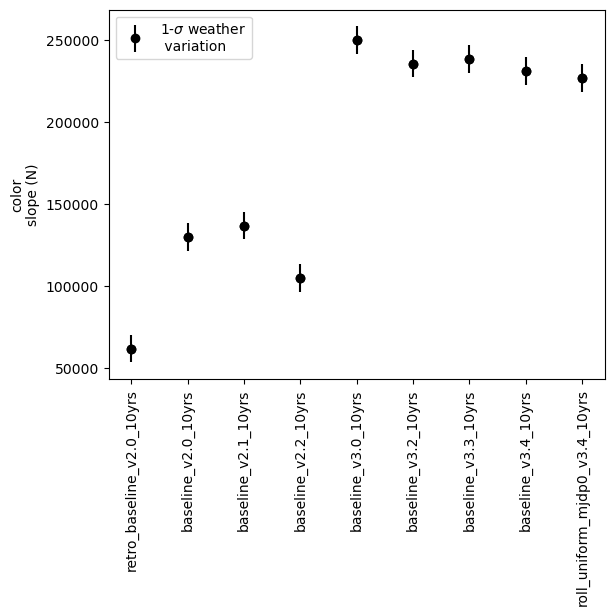

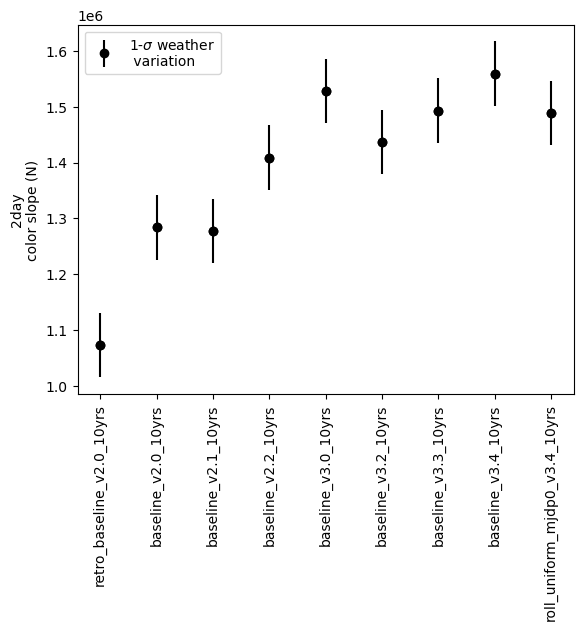

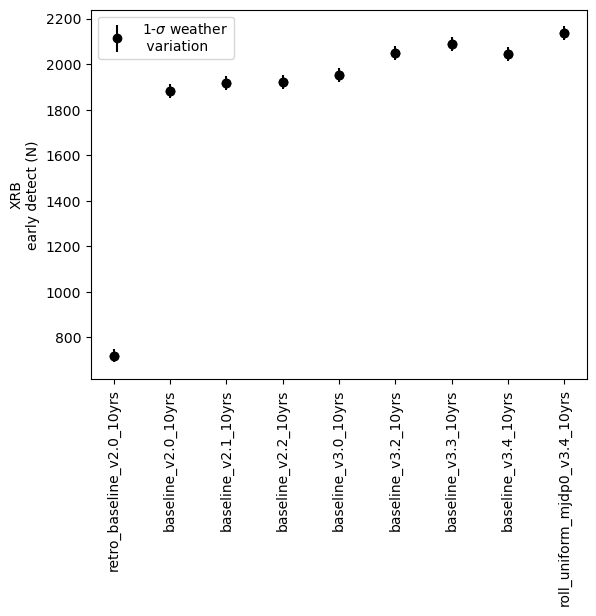

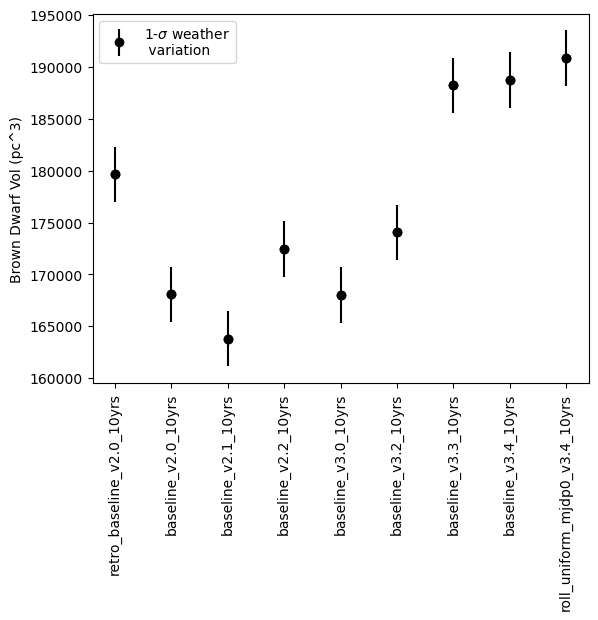

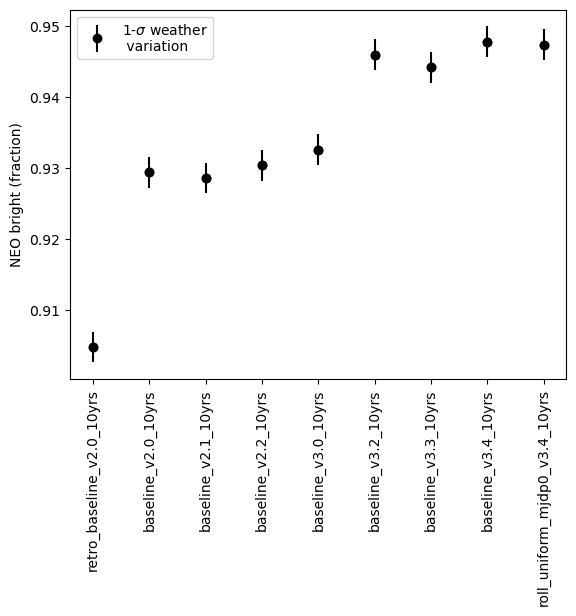

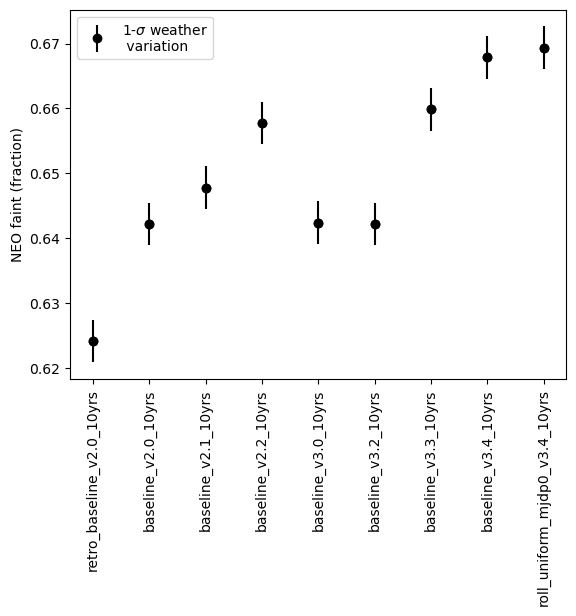

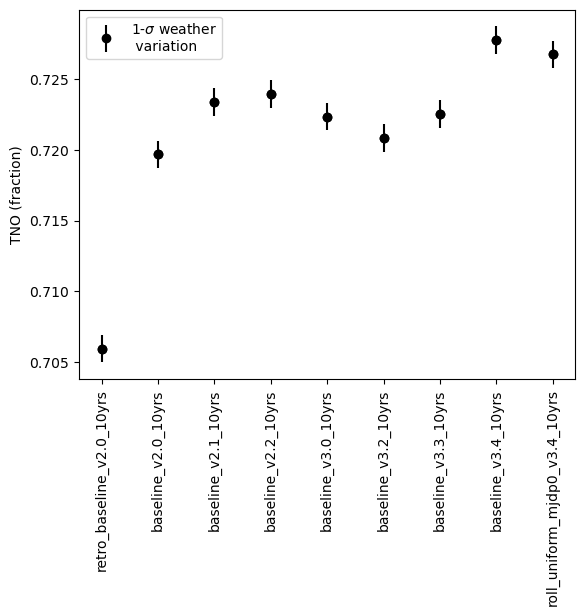

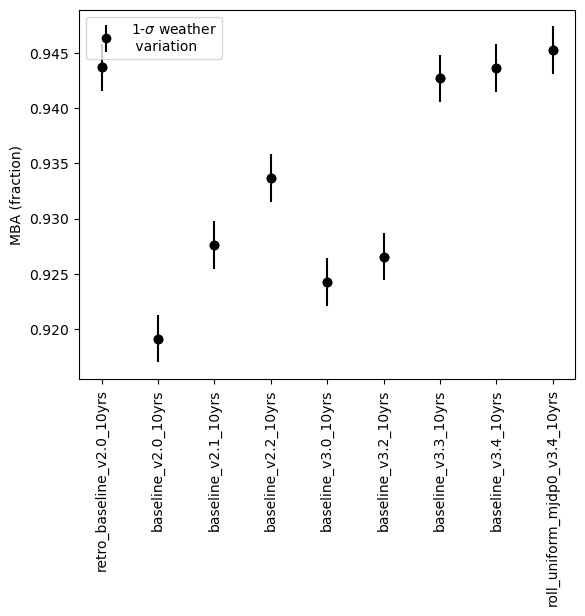

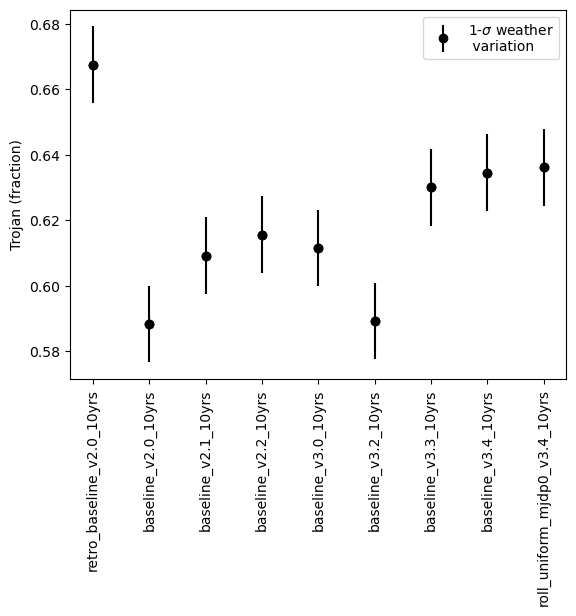

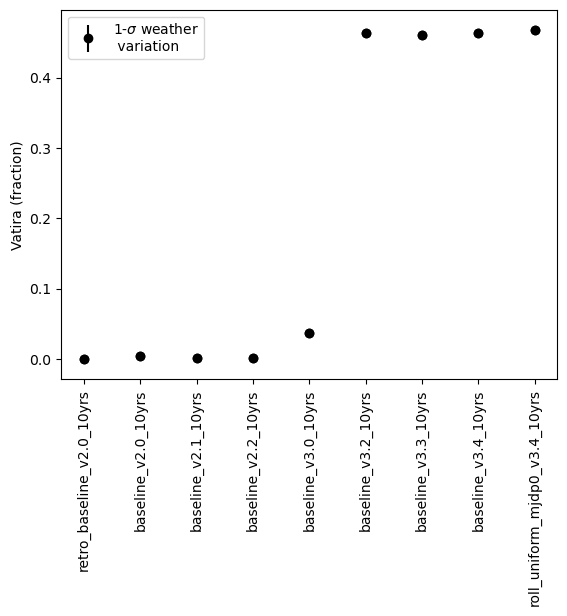

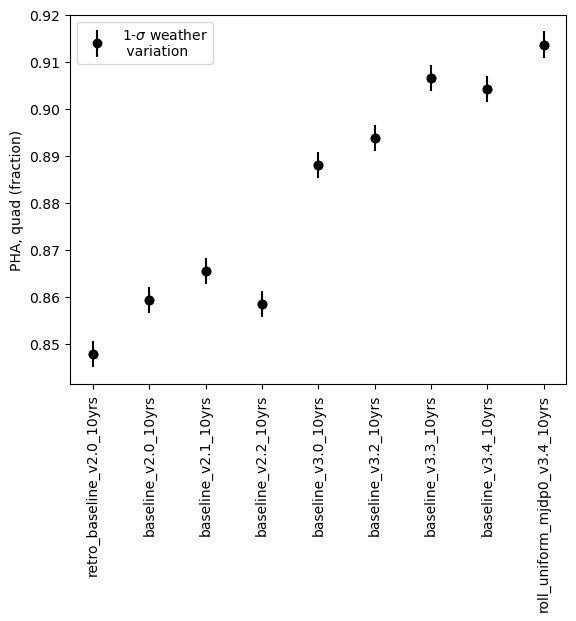

In [10]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


(<Figure size 600x600 with 2 Axes>, <Axes: >)

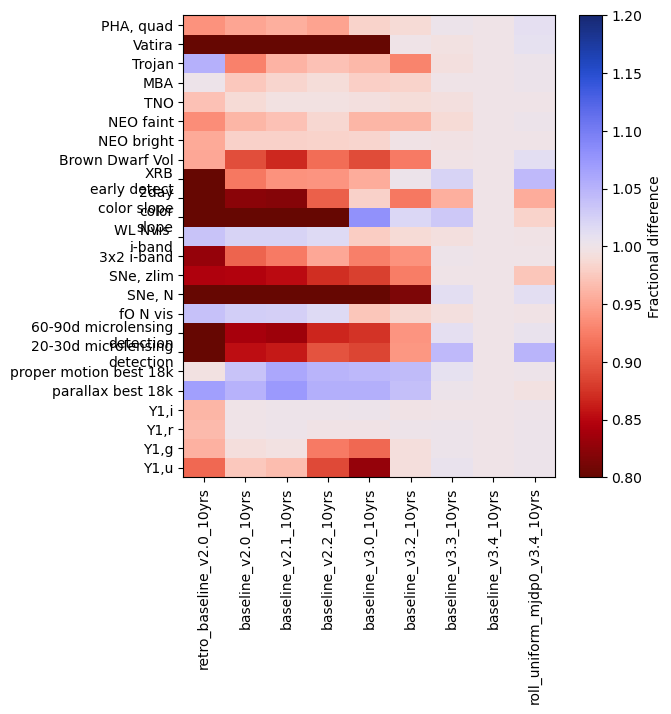

In [28]:
maf.plot_run_metric_mesh(sub_data, baseline_run='baseline_v3.4_10yrs', color_range=0.4)

# No rolling in the LMC/SMC

Very small change to not roll in the LMC/SMC. Does result in a few more microlensing detections, probably because some long gaps are eliminated by not rolling.

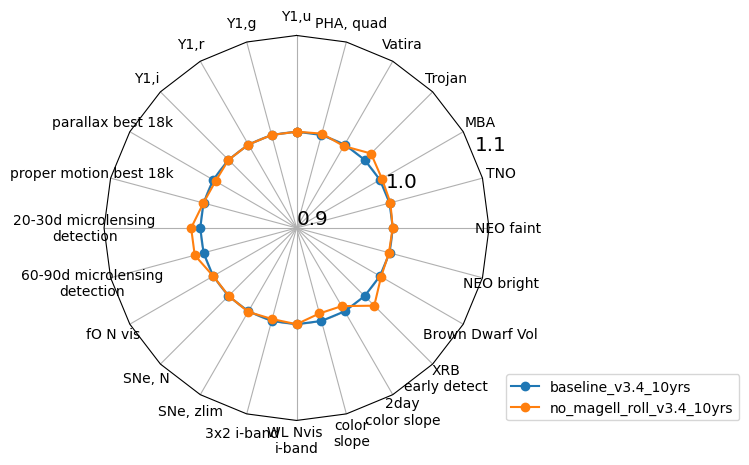

In [12]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'magel' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

# Early NES templates

Taking more images in the NES in year 1 to ensure templates can be made. Pretty minor impact, even when the NES is covered similarly to the WFD in year 1.

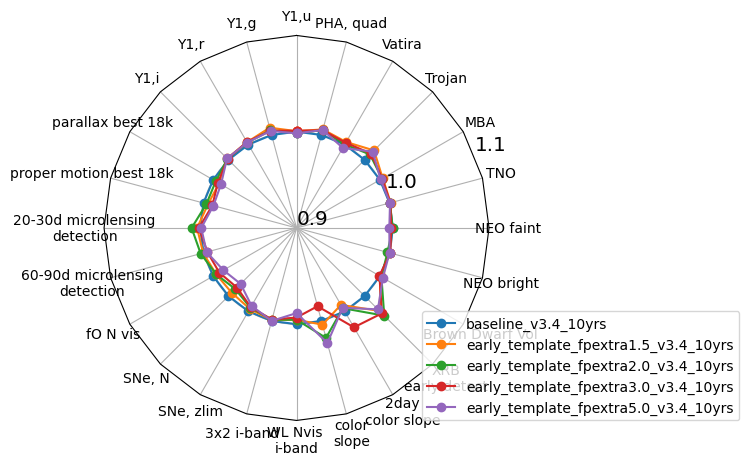

In [13]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'early_' in run and 'roll' not in run and '_u_' not in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

# Going deeper in u-band in northern WFD in the first year

Again, very little change since there are so few u-band observations to start.


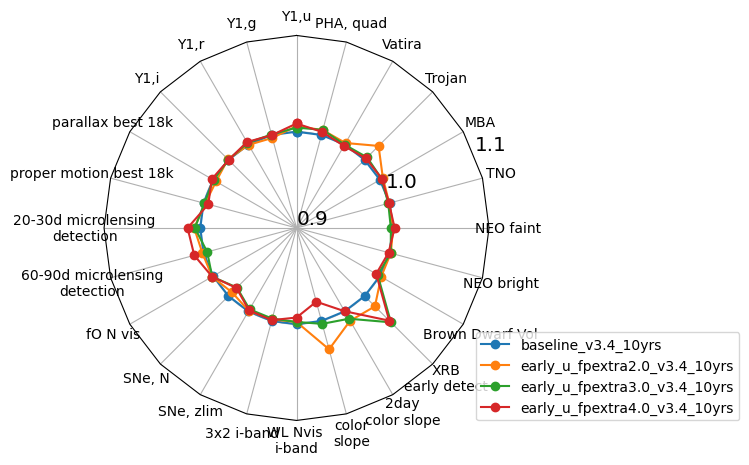

In [14]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'early_' in run and 'roll' not in run and '_template_' not in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

# Vary u-band number of visits and exposure time

Motivation here was that going to tripple-silver coatings boosted depth in everything but u-band. 

Lots of variation, mostly as expected. We don't really have a science case with a metric that clearly depends on either u-band cadence or u-band depth

Going to something like 38s visits in u (and increasing number of u visits ~10%), mostly recovers the u-band depth and has a fairly small impact on everything else. There does seem to be some tradeoff with number of SNe Ia. 

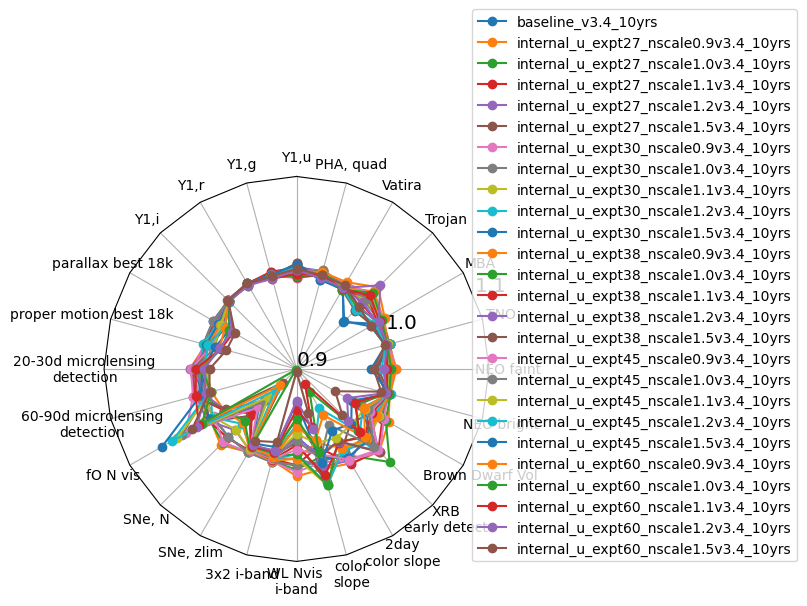

In [15]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'u_exp' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.8, 0))

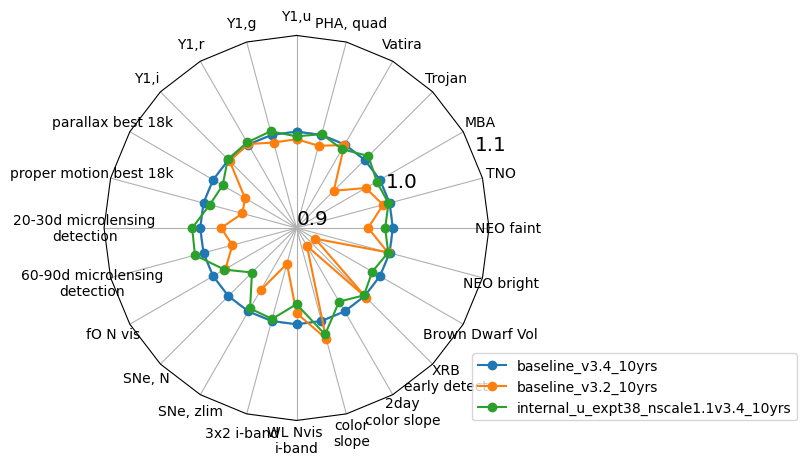

In [16]:
runs = ['baseline_v3.4_10yrs', 'baseline_v3.2_10yrs'] + ['internal_u_expt38_nscale1.1v3.4_10yrs']
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.8, 0))

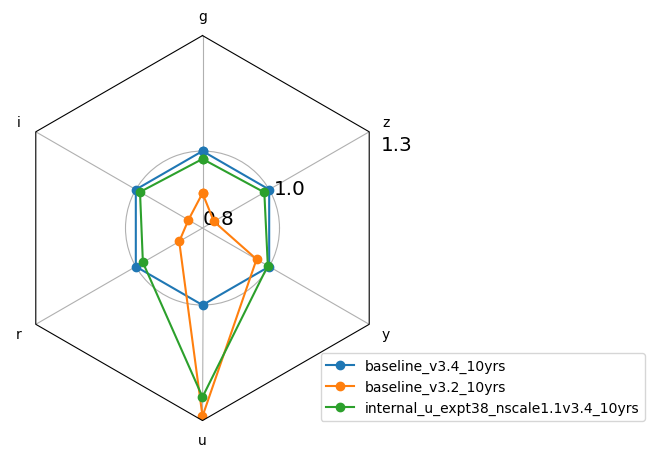

In [17]:
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')#, invert_cols=['u', 'g', 'r', 'i', 'z', 'y'])
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.3], bbox_to_anchor=(1.65, 0))

In [18]:
mag_data.loc[runs]

g          i          r  \
baseline_v3.4_10yrs                    26.787451  26.453652  26.938063   
baseline_v3.2_10yrs                    26.678103  26.295888  26.807880   
internal_u_expt38_nscale1.1v3.4_10yrs  26.766949  26.441070  26.916850   

                                               u          y          z  
baseline_v3.4_10yrs                    25.333755  24.804475  25.752748  
baseline_v3.2_10yrs                    25.622696  24.766647  25.586860  
internal_u_expt38_nscale1.1v3.4_10yrs  25.572575  24.800402  25.738159

# Uniform rolling

Insert non-rolling seasons to that data releases at years 1, 4, 7, and 10 are uniform

As expected, metric variations are similar to changes in survey start date, i.e., this is consistent with a neutral survey strategy change.

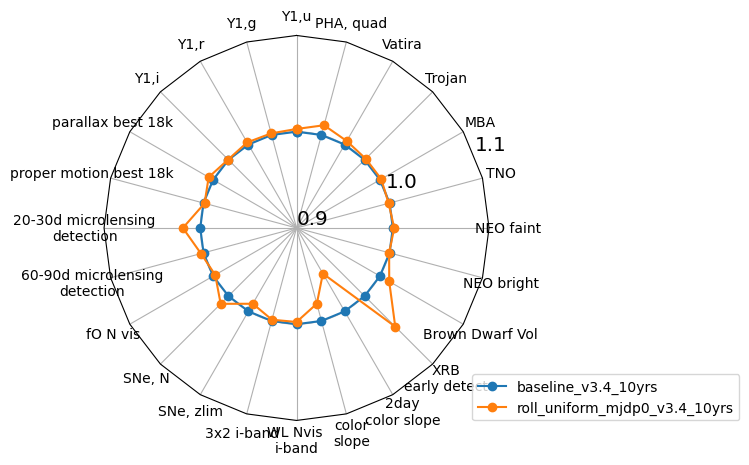

In [19]:
runs = ['baseline_v3.4_10yrs'] + ['roll_uniform_mjdp0_v3.4_10yrs']#[run for run in data.index if 'uniform' in run and 'half' not in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

# Viz of survey uniformity

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


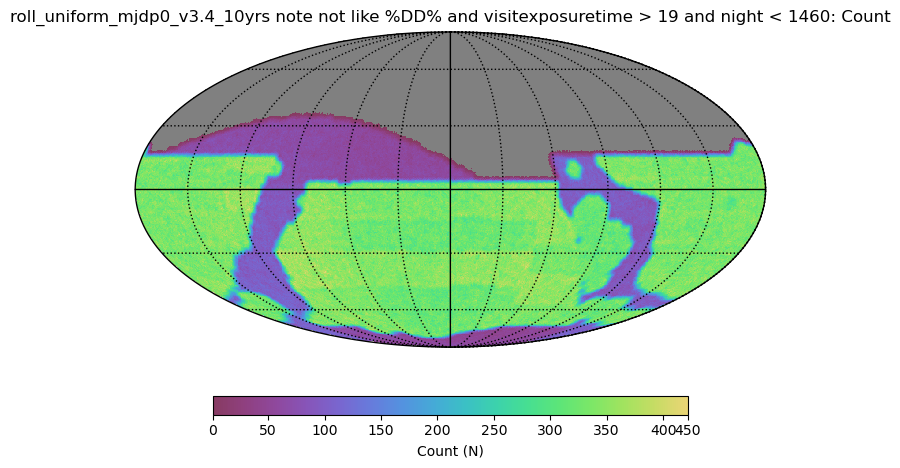

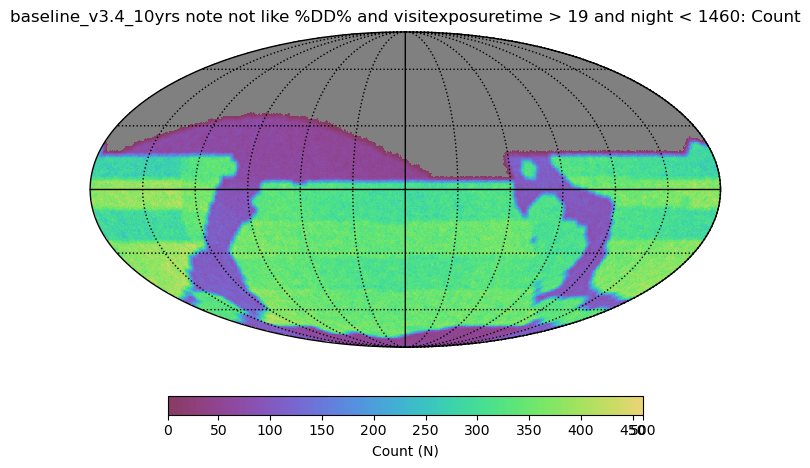

In [20]:
files = glob.glob('../roll_uniform/roll_uniform_mjdp0_v3.4_10yrs.db') + ['../baseline/baseline_v3.4_10yrs.db']
for filename in files:
    bundle_list = []
    run_name = os.path.basename(filename).replace('.db', '')
    sql = "note not like '%%DD%%' and visitexposuretime > 19 and night < %i" % (365*4)
    metric = maf.CountMetric(col='night', units='N', metric_name='Count')
    slicer = maf.HealpixSlicer()
    plot_funcs = [maf.HealpixSkyMap()]
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, plot_funcs=plot_funcs, run_name=run_name))
    

    bd = maf.make_bundles_dict_from_list(bundle_list)
    mbg = maf.MetricBundleGroup(bd, filename, out_dir='temp')
    mbg.run_all()
    mbg.plot_all(closefigs=False)

# Year 1 observations, extra in the NES

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


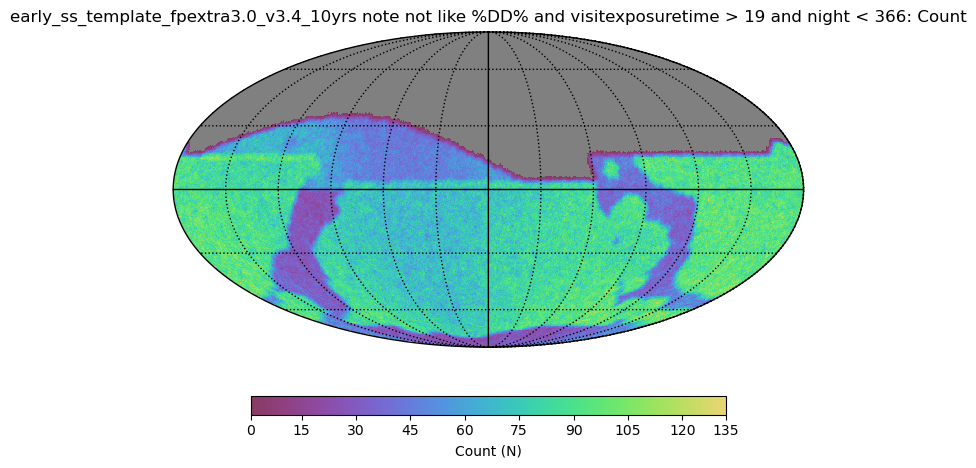

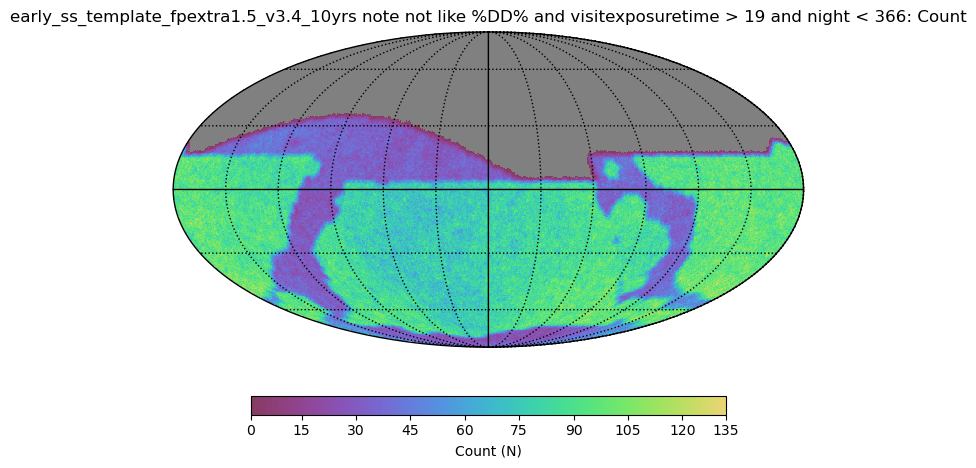

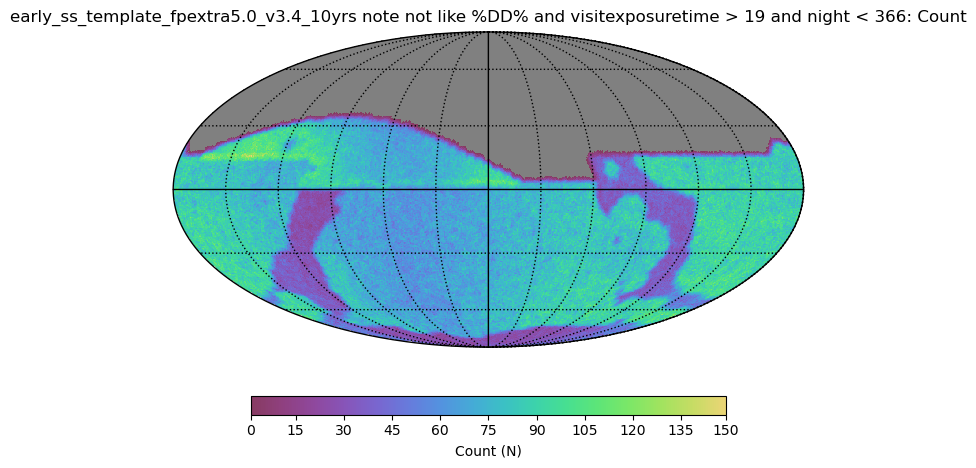

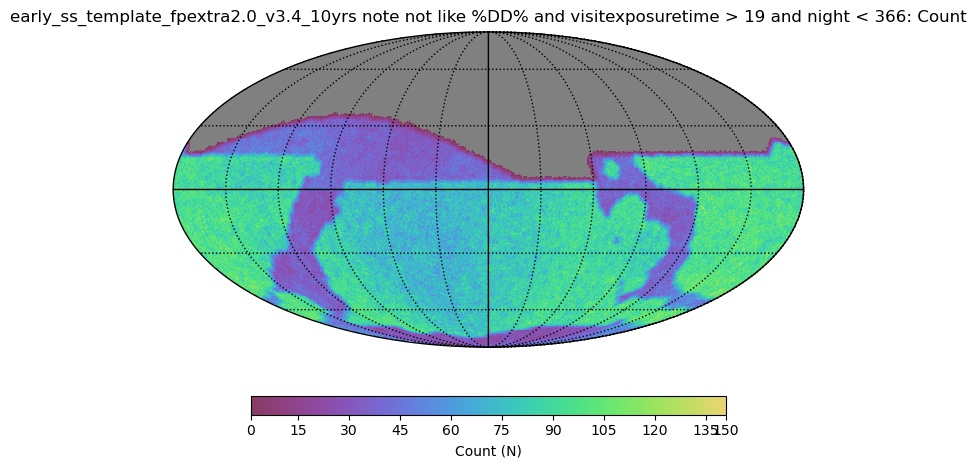

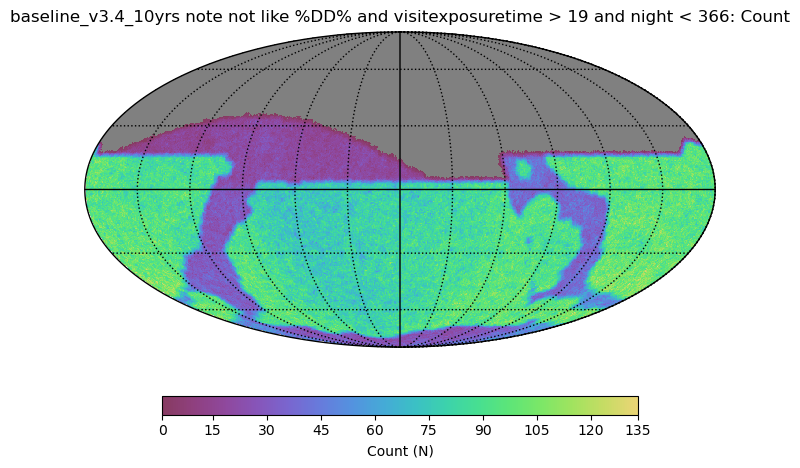

In [21]:
# let's look at year 1 for baseline and the early runs

files = glob.glob('../early_science/early_ss*_10yrs.db') + ['../baseline/baseline_v3.4_10yrs.db']
for filename in files:
    bundle_list = []
    run_name = os.path.basename(filename).replace('.db', '')
    sql = "note not like '%DD%' and visitexposuretime > 19 and night < 366"
    metric = maf.CountMetric(col='night', units='N', metric_name='Count')
    slicer = maf.HealpixSlicer()
    plot_funcs = [maf.HealpixSkyMap()]
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, plot_funcs=plot_funcs, run_name=run_name))
    

    bd = maf.make_bundles_dict_from_list(bundle_list)
    mbg = maf.MetricBundleGroup(bd, filename, out_dir='temp')
    mbg.run_all()
    mbg.plot_all(closefigs=False)

# Year 1 observations, extra in u

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


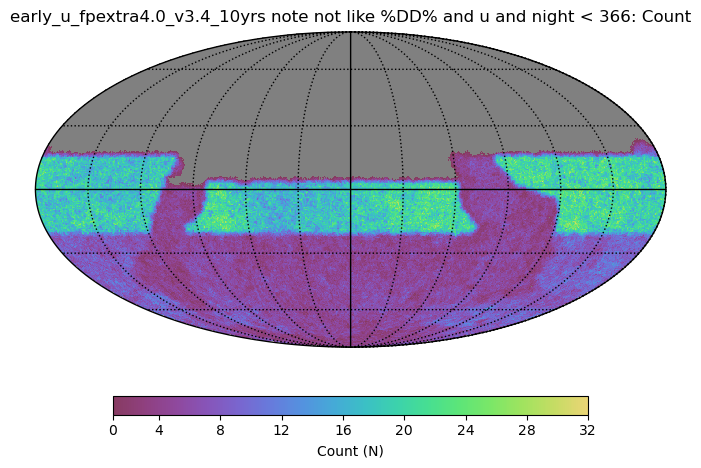

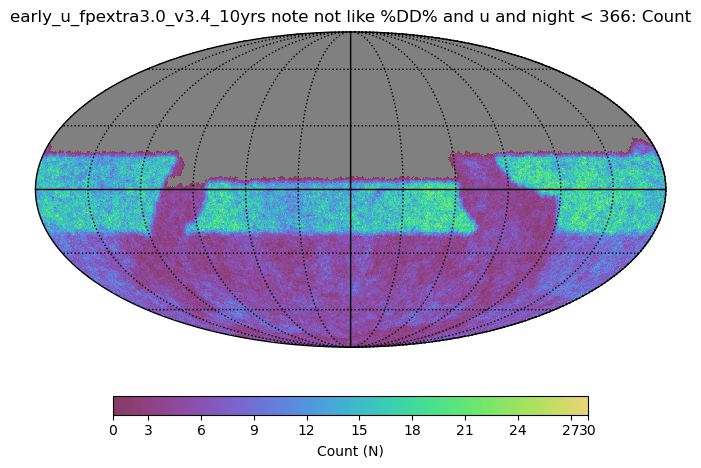

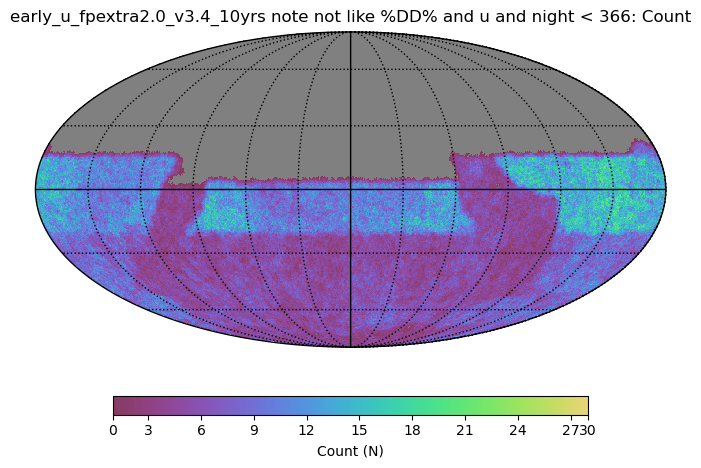

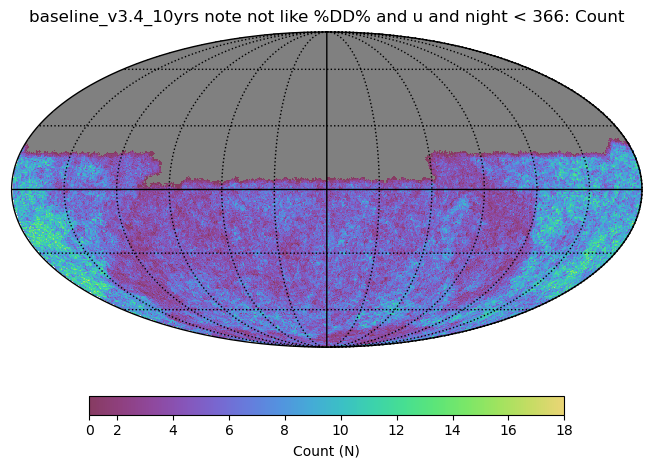

In [22]:
files = glob.glob('../early_science/early_u*_10yrs.db') + ['../baseline/baseline_v3.4_10yrs.db']
for filename in files:
    bundle_list = []
    run_name = os.path.basename(filename).replace('.db', '')
    sql = "note not like '%DD%' and filter='u' and night < 366"
    metric = maf.CountMetric(col='night', units='N', metric_name='Count')
    slicer = maf.HealpixSlicer()
    plot_funcs = [maf.HealpixSkyMap()]
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, plot_funcs=plot_funcs, run_name=run_name))

    bd = maf.make_bundles_dict_from_list(bundle_list)
    mbg = maf.MetricBundleGroup(bd, filename, out_dir='temp')
    mbg.run_all()
    mbg.plot_all(closefigs=False)